In [21]:
from models.q_network import CardFeaturizer
import torch as t
from game.utils import variable
import numpy as np
from game.game_utils import Card, cards_to_array
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from IPython import display

# Load dataset

In [502]:
import pickle
filenames = ['hand_eval_2.p',
             'hand_eval_51511068091.1125414.p',
             'hand_eval_51511071691.158362.p',
             'hand_eval_51511075291.2004554.p',
             'hand_eval_51511078891.2243085.p',
             'hand_eval_51511082491.277018.p',
             'hand_eval_51511086091.2965872.p',
             'hand_eval_51511093291.367359.p',
             'hand_eval_51511100491.4335415.p',
             'hand_eval_51511104091.4605765.p',
             'hand_eval_51511107691.4960084.p']

for filename in filenames:
    with open(filename, 'rb') as f:
        dataset_ = pickle.load(f)
        try:
            for k,v in dataset_.items():
                train_dataset[k] = v
        except:
            train_dataset = dataset_

In [503]:
import pickle
filenames = ['hand_eval_51511089691.300083.p']
for filename in filenames:
    with open(filename, 'rb') as f:
        dataset_ = pickle.load(f)
        try:
            for k,v in dataset_.items():
                test_dataset[k] = v
        except:
            test_dataset = dataset_


In [504]:
len(train_dataset), len(test_dataset)

(669599, 54652)

In [505]:
for k,v in train_dataset.items():
    if v['player1winprob'] > 1:
        print(k,v)
        break

# Parse dataset

frozenset({'2d', '6c', '9d', '7s'})): {'player1winprob': 0.15217391304347827, 'High Card': 0.5217391304347826, 'Pair': 0.391304347826087, 'Two Pair': 0.0, 'Three of a Kind': 0.0, 'Straight': 0.08695652173913043, 'Flush': 0.0, 'Full House': 0.0, 'Four of a Kind': 0.0, 'Straight Flush': 0.0, 'Royal Flush': 0.0}}
Time diff is 0.002004861831665039

In [507]:
def parse_dataset(dataset):
    x_hand = np.zeros((len(dataset), 13, 4))
    x_board = np.zeros((len(dataset), 3, 13, 4))
    y = np.zeros((len(dataset), 10))

    for i, (cards_, probas) in enumerate(dataset.items()):
        # if there are only two cards and nothing on the board then the keys don't have the same format.....
        if isinstance(cards_, tuple):
            hand_, board_ = cards_
        else:
            hand_ = cards_
            board_ = None

        hand = []
        board = []

        for card_ in hand_:
            if card_[0] != 'T':
                try:
                    hand.append(Card(card_[0], card_[1]))
                except:
                    print(hand_, board_)
                    raise Exception
            else:
                hand.append(Card('10', card_[1]))

        if board_ is not None:
            for card_ in board_:
                if card_[0] != 'T':
                    board.append(Card(card_[0], card_[1]))
                else:
                    board.append(Card('10', card_[1]))

        x_hand[i] = cards_to_array(hand)
        x_board[i] = cards_to_array(board)
        y[i][0] = probas['player1winprob']
        y[i][1] = probas['High Card']
        y[i][2] = probas['Pair']
        y[i][3] = probas['Two Pair']
        y[i][4] = probas['Three of a Kind']
        y[i][5] = probas['Straight']
        y[i][6] = probas['Flush']
        y[i][7] = probas['Full House']
        y[i][8] = probas['Four of a Kind']
        y[i][9] = probas['Straight Flush']
    return x_hand, x_board, y


In [509]:
x_hand_train, x_board_train, y_train = parse_dataset(train_dataset)
x_hand_test, x_board_test, y_test = parse_dataset(test_dataset)

# Train neural network

In [511]:
from torch.nn import AlphaDropout, Conv1d as conv, Linear as fc, SELU, Sigmoid

selu = SELU()
sigmoid = Sigmoid()


def get_shape(x):
    try:
        return x.data.numpy().shape
    except:
        return x.numpy().shape


def flatten(x):
    shape = get_shape(x)
    return x.resize(shape[0], int(np.prod(shape[1:])))


class CardFeaturizer(t.nn.Module):
    def __init__(self, hdim):
        super(CardFeaturizer, self).__init__()
        self.hdim = hdim
        self.conv1 = conv(2, 5, 1)
        self.conv2 = conv(5, 1, 5, padding=2)
        self.conv3 = conv(5, 1, 3, padding=1)
        self.conv4 = conv(5, 3, 3, dilation=2, padding=2)
        self.conv5 = conv(2, 1, 1)

        self.fc1 = fc(13 * 5, hdim)
        self.fc2 = fc(13 * 2, hdim)
        self.fc3 = fc(hdim, hdim)
        self.fc4 = fc(4, hdim)
        self.fc5 = fc(52, hdim)
        self.fc6 = fc(hdim, hdim)
        self.fc7 = fc(52, hdim)
        self.fc8 = fc(hdim, hdim)
        self.fc9 = fc(52, hdim)
        self.fc10 = fc(hdim, hdim)
        self.fc11 = fc(3 * hdim, hdim)
        self.fc12 = fc(52, hdim)
        self.fc13 = fc(hdim, hdim)
        self.fc14 = fc(5 * hdim, hdim)
        self.fc15 = fc(hdim, hdim)
#         self.fc17 = fc(hdim, 9)
        self.fc18 = fc(hdim, 1)

    def forward(self, hand, board):
        dropout = AlphaDropout(.1)
        dropout.training = self.training
        
        # DETECTING PATTERNS IN THE BOARD AND HAND
        # Aggregate by suit and kind
        color_hand = t.sum(hand, 1)
        color_board = t.sum(t.sum(board, 2), 1)
        kinds_hand = t.sum(hand, -1)
        kinds_board = t.sum(t.sum(board, -1), 1)
        colors = t.cat([color_hand.resize(len(color_hand), 1, 4), color_board.resize(len(color_board), 1, 4)], 1)
        kinds = t.cat([kinds_hand.resize(len(kinds_hand), 1, 13), kinds_board.resize(len(kinds_board), 1, 13)], 1)

        # Process board and hand to detect straights using convolutions with kernel size 5, 3, and 3 with dilation
        kinds_straight = selu(dropout(self.conv1((kinds > 0).float())))
        kinds_straight = t.cat([
            selu(dropout(self.conv2(kinds_straight))),
            selu(dropout(self.conv3(kinds_straight))),
            selu(dropout(self.conv4(kinds_straight)))
        ], 1)
        kinds_straight = flatten(kinds_straight)
        kinds_straight = selu(dropout(self.fc1(kinds_straight)))

        # Process board and hand to detect pairs, trips, quads, full houses
        kinds_ptqf = selu(dropout(self.fc2(flatten(kinds))))
        kinds_ptqf = selu(dropout(self.fc3(kinds_ptqf)))

        # Process board and hand to detect flushes
        colors = flatten(selu(dropout(self.conv5(colors))))
        colors = selu(dropout(self.fc4(colors)))

        # Process the board with FC layers
        flop_alone = selu(dropout(self.fc5(flatten(board[:, 0, :, :]))))
        flop_alone = selu(dropout(self.fc6(flop_alone)))
        turn_alone = selu(dropout(self.fc7(flatten(board[:, 1, :, :]))))
        turn_alone = selu(dropout(self.fc8(turn_alone)))
        river_alone = selu(dropout(self.fc9(flatten(board[:, 2, :, :]))))
        river_alone = selu(dropout(self.fc10(river_alone)))
        board_alone = selu(dropout(self.fc11(t.cat([flop_alone, turn_alone, river_alone], -1))))

        # Process board and hand together with FC layers
        h = selu(dropout(self.fc12(flatten(hand))))
        h = selu(dropout(self.fc13(h)))
        bh = selu(dropout(self.fc14(t.cat([h, board_alone, colors, kinds_ptqf, kinds_straight], -1))))
        bh = selu(dropout(self.fc15(bh)))

        # Predict probabilities of having a given hand + hand strength
#         probabilities_of_each_combination = softmax(self.fc17(bh))
        hand_strength = sigmoid(self.fc18(bh))
        return hand_strength


In [512]:
from torch.nn import AlphaDropout, Conv1d as conv, Linear as fc, Sigmoid, BatchNorm1d as BN, PReLU

sigmoid = Sigmoid()


def get_shape(x):
    try:
        return x.data.numpy().shape
    except:
        return x.numpy().shape


def flatten(x):
    shape = get_shape(x)
    return x.resize(shape[0], int(np.prod(shape[1:])))


class CardFeaturizer(t.nn.Module):
    def __init__(self, hdim):
        super(CardFeaturizer, self).__init__()
        self.hdim = hdim
        self.conv1 = conv(2, 5, 1)
        self.conv1_bn = BN(5)
        self.conv2 = conv(5, 1, 5, padding=2)
        self.conv2_bn = BN(1)
        self.conv3 = conv(5, 1, 3, padding=1)
        self.conv3_bn = BN(1)
        self.conv4 = conv(5, 3, 3, dilation=2, padding=2)
        self.conv4_bn = BN(3)
        self.conv5 = conv(2, 1, 1)
        self.conv5_bn = BN(1)

        self.fc1 = fc(13 * 5, hdim)
        self.fc1_bn = BN(hdim)
        self.fc2 = fc(13 * 2, hdim)
        self.fc2_bn = BN(hdim)
        self.fc3 = fc(hdim, hdim)
        self.fc3_bn = BN(hdim)
        self.fc4 = fc(4, hdim)
        self.fc4_bn = BN(hdim)
        self.fc5 = fc(52, hdim)
        self.fc5_bn = BN(hdim)
        self.fc6 = fc(hdim, hdim)
        self.fc6_bn = BN(hdim)
        self.fc7 = fc(52, hdim)
        self.fc7_bn = BN(hdim)
        self.fc8 = fc(hdim, hdim)
        self.fc8_bn = BN(hdim)
        self.fc9 = fc(52, hdim)
        self.fc9_bn = BN(hdim)
        self.fc10 = fc(hdim, hdim)
        self.fc10_bn = BN(hdim)
        self.fc11 = fc(3 * hdim, hdim)
        self.fc11_bn = BN(hdim)
        self.fc12 = fc(52, hdim)
        self.fc12_bn = BN(hdim)
        self.fc13 = fc(hdim, hdim)
        self.fc13_bn = BN(hdim)
        self.fc14 = fc(5 * hdim, hdim)
        self.fc14_bn = BN(hdim)
        self.fc15 = fc(hdim, hdim)
        self.fc15_bn = BN(hdim)
#         self.fc17 = fc(hdim, 9)
        self.fc18 = fc(hdim, 1)
    

    def forward(self, hand, board, ret_features=False):
        hdim = self.hdim
        
        # DETECTING PATTERNS IN THE BOARD AND HAND
        # Aggregate by suit and kind
        color_hand = t.sum(hand, 1)
        color_board = t.sum(t.sum(board, 2), 1)
        kinds_hand = t.sum(hand, -1)
        kinds_board = t.sum(t.sum(board, -1), 1)
        colors = t.cat([color_hand.resize(len(color_hand), 1, 4), color_board.resize(len(color_board), 1, 4)], 1)
        kinds = t.cat([kinds_hand.resize(len(kinds_hand), 1, 13), kinds_board.resize(len(kinds_board), 1, 13)], 1)

        # Process board and hand to detect straights using convolutions with kernel size 5, 3, and 3 with dilation
        kinds_straight = PReLU(5)(self.conv1_bn(self.conv1((kinds > 0).float())))
        kinds_straight = t.cat([
            PReLU(1)(self.conv2_bn(self.conv2(kinds_straight))),
            PReLU(1)(self.conv3_bn(self.conv3(kinds_straight))),
            PReLU(3)(self.conv4_bn(self.conv4(kinds_straight)))
        ], 1)
        kinds_straight = flatten(kinds_straight)
        kinds_straight = PReLU(1)(self.fc1_bn(self.fc1(kinds_straight)))

        # Process board and hand to detect pairs, trips, quads, full houses
        kinds_ptqf = PReLU(hdim)(self.fc2_bn(self.fc2(flatten(kinds))))
        kinds_ptqf = PReLU(hdim)(self.fc3_bn(self.fc3(kinds_ptqf)))

        # Process board and hand to detect flushes
        colors = flatten(PReLU(1)(self.conv5_bn(self.conv5(colors))))
        colors = PReLU(hdim)(self.fc4_bn(self.fc4(colors)))

        # Process the board with FC layers
        flop_alone = PReLU(hdim)(self.fc5_bn(self.fc5(flatten(board[:, 0, :, :]))))
        flop_alone = PReLU(hdim)(self.fc6_bn(self.fc6(flop_alone)))
        turn_alone = PReLU(hdim)(self.fc7_bn(self.fc7(flatten(board[:, 1, :, :]))))
        turn_alone = PReLU(hdim)(self.fc8_bn(self.fc8(turn_alone)))
        river_alone = PReLU(hdim)(self.fc9_bn(self.fc9(flatten(board[:, 2, :, :]))))
        river_alone = PReLU(hdim)(self.fc10_bn(self.fc10(river_alone)))
        board_alone = PReLU(hdim)(self.fc11_bn(self.fc11(t.cat([flop_alone, turn_alone, river_alone], -1))))

        # Process board and hand together with FC layers
        h = PReLU(hdim)(self.fc12_bn(self.fc12(flatten(hand))))
        h = PReLU(hdim)(self.fc13_bn(self.fc13(h)))
        bh = PReLU(hdim)(self.fc14_bn(self.fc14(t.cat([h, board_alone, colors, kinds_ptqf, kinds_straight], -1))))
        bh = PReLU(hdim)(self.fc15_bn(self.fc15(bh)))

        # Predict probabilities of having a given hand + hand strength
#         probabilities_of_each_combination = softmax(self.fc17(bh))
        hand_strength = sigmoid(self.fc18(bh))
        if not ret_features:
            return hand_strength
        else:
            return hand_strength, bh, flop_alone, turn_alone, river_alone


In [538]:
f = CardFeaturizer(20)
print('#params: ', np.sum([np.prod(p.data.numpy().shape) for p in f.parameters()]))

#params:  12711


In [539]:
def moving_avg(x, window=50):
    return [np.mean(x[k:k+window]) for k in range(len(x)-window)]

In [540]:
# # initialization of weights for using selu activation

# for i in range(1, 19):
#     if i == 16 or i == 17:
#         continue
#     fcc = getattr(f, 'fc'+str(i))
#     shape = fcc.weight.data.numpy().shape
#     fcc.weight.data = t.from_numpy(np.random.normal(0, 1/np.sqrt(shape[0]), shape)).float()

# for i in range(1, 6):
#     convv = getattr(f, 'conv'+str(i))
#     shape = convv.weight.data.numpy().shape
#     convv.weight.data = t.from_numpy(np.random.normal(0, 1/shape[-1], shape)).float()


In [541]:
def clip_gradients(nn, bound=10):
    for p in nn.parameters():
        if p.grad is not None:
            p.grad = p.grad*((bound <= p.grad).float())*((bound >= p.grad).float()) + bound*((p.grad > bound).float()) - bound*((p.grad < -bound).float())

In [542]:
def clip(p):
    return .99*(p > 0.99).float() + .01 * (p<.01).float() + p*(p>=0.01).float()*(p<=0.99).float()

epoch 0


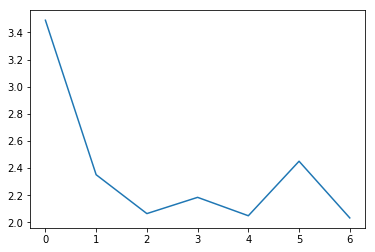

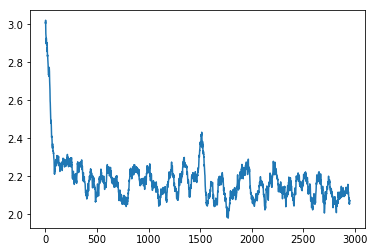

In [ ]:
lr = 1e-1  # 1e-4 for selu
batch_size = 64
EPOCHS = 50
optimizer = t.optim.Adam(f.parameters(), lr=lr, weight_decay=1e-2)
train_losses = []
test_losses = []
PLOT = 500


for _ in range(EPOCHS):
    print('epoch', _)
    x_hand_train, x_board_train, y_train = shuffle(x_hand_train, x_board_train, y_train)
    
    # check if weights are NaN
    for p in f.parameters():
        if np.isnan(p.data.numpy()).sum()>0:
            raise ValueError('nan weights !')
    
    for i in range(0, len(dataset), batch_size):
        hand = variable(x_hand_train[i:i+batch_size])
        board = variable(x_board_train[i:i+batch_size])
        target = clip(variable(y_train[i:i+batch_size, 0])).squeeze()
        
        optimizer.zero_grad()

        HS = f.forward(hand, board).squeeze()+1e-5
        pred = t.log(HS/(1-HS))
        true = t.log(target / (1-target))
        loss = (true - pred)**2
        loss = t.sum(loss)
        train_losses.append(loss.data.numpy()[0]/batch_size)
        
        loss.backward()
#         clip_gradients(f, 5)
        
        optimizer.step()
        
        if (i//batch_size) % PLOT == 0:
            display.clear_output(wait=True)
            print('epoch', _)
            
            # test loss on a random test sample
            x_hand_test, x_board_test, y_test = shuffle(x_hand_test, x_board_test, y_test)
            hand = variable(x_hand_test[:1000])
            board = variable(x_board_test[:1000])
            target = clip(variable(y_test[:1000, 0])).squeeze()
            HS = f.forward(hand, board).squeeze() + 1e-5
            pred = t.log(HS/(1-HS))
            true = t.log(target / (1-target))
            loss = (true - pred)**2
            loss = t.sum(loss)      
            test_losses.append(loss.data.numpy()[0]/1000)
            
            # plot
            plt.plot(test_losses)
            plt.show()
            plt.plot(moving_avg(train_losses))
            plt.show()

Test of the model

In [377]:
IDX_TO_RANK = {k:v for k,v in enumerate(Card.RANKS)}
IDX_TO_SUIT = {k:v for k,v in enumerate(Card.SUITS)}

def array_to_card(array):
    if isinstance(array, t.autograd.Variable):
        array_ = array.data.numpy()
    else:
        array_ = array
    cards = []
    for i in range(13):
        for j in range(4):
            if array_[i][j] == 1:
                cards.append(Card(IDX_TO_RANK[i], IDX_TO_SUIT[j]))
    return cards


In [378]:
def c(r, s):
    return Card(r, s)

In [379]:
hand = variable(cards_to_array([c('Q','s'), c('K', 'h')])).resize(1,13,4)
board1 = variable(cards_to_array([c('2','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board2 = variable(cards_to_array([c('3','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board3 = variable(cards_to_array([c('4','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board4 = variable(cards_to_array([c('2','s'),c('7','h'),c('Q','h')])).resize(1,3,13,4)
board5 = variable(cards_to_array([c('2','c'),c('6','h'),c('Q','h')])).resize(1,3,13,4)
board6 = variable(cards_to_array([c('2','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board7 = variable(cards_to_array([c('2','d'),c('3','h'),c('Q','h')])).resize(1,3,13,4)
print(f(hand,board1).data.numpy()[0], f(hand,board2).data.numpy()[0], f(hand,board3).data.numpy()[0], f(hand,board4).data.numpy()[0], f(hand,board5).data.numpy()[0], f(hand,board6).data.numpy()[0], f(hand,board7).data.numpy()[0])

[ 0.50788301] [ 0.50788301] [ 0.50788301] [ 0.50788301] [ 0.50788301] [ 0.50788301] [ 0.50788301]


In [382]:
t.sum((f(hand,board1,True)[1] - f(hand,board2,True)[1])**2)

Variable containing:
 0
[torch.FloatTensor of size 1]

In [ ]:
hand = variable(cards_to_array([c('Q','s'), c('K', 'h')])).resize(1,13,4)
board1 = variable(cards_to_array([c('2','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board2 = variable(cards_to_array([c('3','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board3 = variable(cards_to_array([c('4','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board4 = variable(cards_to_array([c('2','s'),c('7','h'),c('Q','h')])).resize(1,3,13,4)
board5 = variable(cards_to_array([c('2','c'),c('6','h'),c('Q','h')])).resize(1,3,13,4)
board6 = variable(cards_to_array([c('2','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board7 = variable(cards_to_array([c('2','d'),c('3','h'),c('Q','h')])).resize(1,3,13,4)
print(f(hand,board1).data.numpy()[0], f(hand,board2).data.numpy()[0], f(hand,board3).data.numpy()[0], f(hand,board4).data.numpy()[0], f(hand,board5).data.numpy()[0], f(hand,board6).data.numpy()[0], f(hand,board7).data.numpy()[0])

In [348]:
pred = f.forward(hand,board).squeeze()
for i in range(64):
    print(array_to_card(hand[i]), array_to_card(t.sum(board[i],0)), target[i, 0].data.numpy()[0], pred[i].data.numpy()[0])

[Qs, Kh] [2c, 5h, Qh] 0.966698 0.778745
[9s, Jc] [5s, 8c, 8s] 0.0749306 0.382089
[Ah, As] [6c, 8h, 8s] 0.880666 0.801867
[5s, 10c] [8c, 9c, 10d] 0.701203 0.606154
[Qh, Ad] [10d, Jd, Kc] 0.931545 0.721236
[7h, Kh] [3s, 6h, 6d] 0.66235 0.478504
[7s, 8c] [3h, 7h, Qh] 0.427382 0.457862
[5s, 9s] [6d, 7c, 10h] 0.122109 0.360921
[7s, Qs] [6c, 6s, Jh] 0.0323774 0.411266
[2d, 7s] [6s, 9c, Ks] 0.271045 0.177152
[3s, 9d] [4c, 6h, 8c] 0.20444 0.171122
[5h, 6c] [9c, 10s, Ks] 0.0222017 0.13152
[7h, 9h] [5s, 7s, Qh] 0.856614 0.622722
[Js, Ks] [8h, 9c, Jh] 0.768733 0.716049
[10d, Qh] [3h, Jc, Js] 0.680851 0.473144
[2d, 6c] [2c, 6s, Kd] 0.679926 0.83905
[6c, Qs] [2d, 8s, As] 0.052729 0.385707
[8s, 10d] [3s, 10s, Js] 0.0277521 0.684515
[10d, Kh] [6s, 9h, 10s] 0.696577 0.748586
[4d, 5c] [2h, 5s, 9d] 0.13506 0.544345
[Ah, As] [3d, Ks, Ac] 0.86679 0.927844
[5c, 6h] [Jc, Qd, Kd] 0.013876 0.134728
[Qh, Kh] [3s, 6s, Js] 0.0962072 0.345087
[7d, Ks] [8c, Qh, Ac] 0.0111008 0.390913
[4c, Js] [2h, 4s, Ad] 0.707678

In [384]:
{len(k[1]) for k in dataset if type(k) == tuple}

{3}

In [334]:
for x, y in zip(f.forward(hand,board).squeeze(), target[:, 0]):
    print(x.data.numpy()[0],y.data.numpy()[0])

0.778745 0.966698
0.382089 0.0749306
0.801867 0.880666
0.606154 0.701203
0.721236 0.931545
0.478504 0.66235
0.457862 0.427382
0.360921 0.122109
0.411266 0.0323774
0.177152 0.271045
0.171122 0.20444
0.13152 0.0222017
0.622722 0.856614
0.716049 0.768733
0.473144 0.680851
0.83905 0.679926
0.385707 0.052729
0.684515 0.0277521
0.748586 0.696577
0.544345 0.13506
0.927844 0.86679
0.134728 0.013876
0.345087 0.0962072
0.390913 0.0111008
0.54047 0.707678
0.696135 0.742831
0.402841 0.153562
0.362011 0.123034
0.286604 0.376503
0.498416 0.468085
0.463262 0.258094
0.231371 0.135985
0.402751 0.155412
0.61832 0.498612
0.499904 0.185014
0.786666 0.833488
0.502752 0.838113
0.788471 0.991674
0.350825 0.277521
0.0921521 0.168363
0.755491 0.769658
0.379987 0.113784
0.413274 0.790009
0.788773 0.827937
0.47279 0.791859
0.370153 0.444033
0.568254 0.0786309
0.478175 0.721554
0.505278 0.120259
0.329461 0.703978
0.630949 0.740981
0.333381 0.0416281
0.381523 0.0333025
0.353993 0.0166512
0.267162 0.350601
0.339872